# Kaggle New York Stock Exchange Prediction

S&P 500 companies historical prices with fundamental data

* https://www.kaggle.com/dgawlik/nyse

주가 예측은 기본적으로 random walk인 그래프를 예측하는 것이기 때문에 자기 자신의 그래프 또는 과거의 데이터만 가지고서는 예측할수가 없습니다. <br> 
해당 문서에서는 다른 회사의 주식 가격과 더불어 해당 회사의 연도별 회계자료를 통해 예측을 하고자 합니다. 

In [1]:
%pylab inline
import pandas as pd

from IPython.display import display, HTML
from collections import Counter

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Bidirectional, Merge, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate, concatenate
from keras.activations import relu
from keras.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor


from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_validation import train_test_split

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

pd.set_option('display.max_columns', 500)

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
CORRELATED_COMPANY_N = 16
COMPANY_SYMBOL = 'AAL'
BATCH_SIZE=32
TRAIN_SIZE=45

# RAW Data 
## securities.csv

기업에 대한 분류및 기타 정보

In [3]:
securities = pd.read_csv('/dataset/stock-market/nyse/securities.csv')

# GICS Sector를 카테고리로 만듬
securities['Sector'] = securities['GICS Sector'].astype('category').cat.codes

display(HTML('<h3>securities.csv</h3>'))
print('Shape:', securities.shape)
display(securities.head())

display(HTML('<h3>예측하려는 회사의 정보</h3>'))
display(securities[securities['Ticker symbol'] == COMPANY_SYMBOL])

Shape: (505, 9)


,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK,Sector
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740,5
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,4
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,4
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,6
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877,6


,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK,Sector
28,AAL,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",2015-03-23,6201,5


## fundamentals.csv

년도별 기업의 회계자료

In [4]:
fundamentals = pd.read_csv('/dataset/stock-market/nyse/fundamentals.csv', index_col=0)
fundamentals['Period Ending'] = pd.to_datetime(fundamentals['Period Ending'])
fundamentals = fundamentals.dropna()

FUNDAMENTAL_COLUMNS = ['Accounts Payable',
                       'Accounts Receivable', "Add'l income/expense items", 'After Tax ROE',
                       'Capital Expenditures', 'Capital Surplus', 'Cash Ratio',
                       'Cash and Cash Equivalents', 'Changes in Inventories', 'Common Stocks',
                       'Cost of Revenue', 'Current Ratio', 'Deferred Asset Charges',
                       'Deferred Liability Charges', 'Depreciation',
                       'Earnings Before Interest and Tax', 'Earnings Before Tax',
                       'Effect of Exchange Rate',
                       'Equity Earnings/Loss Unconsolidated Subsidiary', 'Fixed Assets',
                       'Goodwill', 'Gross Margin', 'Gross Profit', 'Income Tax',
                       'Intangible Assets', 'Interest Expense', 'Inventory', 'Investments',
                       'Liabilities', 'Long-Term Debt', 'Long-Term Investments',
                       'Minority Interest', 'Misc. Stocks', 'Net Borrowings', 'Net Cash Flow',
                       'Net Cash Flow-Operating', 'Net Cash Flows-Financing',
                       'Net Cash Flows-Investing', 'Net Income', 'Net Income Adjustments',
                       'Net Income Applicable to Common Shareholders',
                       'Net Income-Cont. Operations', 'Net Receivables', 'Non-Recurring Items',
                       'Operating Income', 'Operating Margin', 'Other Assets',
                       'Other Current Assets', 'Other Current Liabilities', 'Other Equity',
                       'Other Financing Activities', 'Other Investing Activities',
                       'Other Liabilities', 'Other Operating Activities',
                       'Other Operating Items', 'Pre-Tax Margin', 'Pre-Tax ROE',
                       'Profit Margin', 'Quick Ratio', 'Research and Development',
                       'Retained Earnings', 'Sale and Purchase of Stock',
                       'Sales, General and Admin.',
                       'Short-Term Debt / Current Portion of Long-Term Debt',
                       'Short-Term Investments', 'Total Assets', 'Total Current Assets',
                       'Total Current Liabilities', 'Total Equity', 'Total Liabilities',
                       'Total Liabilities & Equity', 'Total Revenue', 'Treasury Stock',
                       'Earnings Per Share', 'Estimated Shares Outstanding']

def fundamentals_standardization(data):
    fundamental_scaler = StandardScaler()
    data[FUNDAMENTAL_COLUMNS] = fundamental_scaler.fit_transform(data[FUNDAMENTAL_COLUMNS])
    return fundamental_scaler

fundamental_scaler = fundamentals_standardization(fundamentals)

# Target Company
fdm_company = fundamentals[fundamentals['Ticker Symbol'] == COMPANY_SYMBOL]

display(fundamentals.head())

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,2012-12-31,-0.086035,-0.279785,-2.703533,-0.097020,-0.123244,0.051639,-0.208217,-0.159666,0.192495,-0.195995,-0.099624,-0.842945,-0.207319,-0.332174,-0.065782,-0.714485,-0.793056,0.299418,-0.126814,0.172908,-0.514752,0.504033,0.489305,-0.637361,-0.163229,0.934114,-0.285141,0.182437,0.312047,0.044115,-0.201007,-0.137621,-0.23287,-0.664334,0.074609,-0.287597,0.385980,0.120128,-0.844467,1.164431,-0.843385,-1.254282,-0.258104,0.168263,-0.414781,-0.832274,0.554878,-0.056075,1.425766,-0.843813,3.224260,0.144747,2.029670,-0.118436,0.091423,-0.315517,-0.096903,-0.274099,-0.626672,-0.312426,-0.678030,0.290847,1.118052,0.159958,0.347843,-0.072886,-0.070032,0.336829,-0.960690,0.272989,-0.223905,0.078146,0.251187,2012.0,-1.778767,-0.246674
1,AAL,2013-12-31,0.169587,-0.036497,-3.708721,0.079126,-0.486017,0.734139,0.010597,0.115479,0.192495,-0.215641,-0.084166,-0.637243,-0.207319,-0.191685,-0.057914,-0.634982,-0.749141,0.299418,-0.126814,0.443690,0.062959,0.548789,0.586905,-0.522659,0.032119,1.469176,-0.176559,-0.342454,-0.323817,0.788208,-0.201007,-0.137621,-0.23287,0.529291,0.280910,-0.384880,1.305226,-0.364284,-0.834462,1.045077,-0.833377,-1.341876,-0.184060,0.334439,-0.186113,-0.638914,0.621043,0.506661,2.557011,-0.483568,3.638637,0.293865,1.992070,0.015948,0.095052,-0.406789,0.036635,-0.333069,-0.421340,-0.312426,-0.745522,0.290847,1.110308,0.170517,1.086006,0.357554,0.430957,0.815652,-0.672564,0.980509,0.358048,0.120217,0.274049,2013.0,-2.905463,-0.419296
2,AAL,2014-12-31,0.128436,-0.162856,-0.314562,0.383379,-1.136109,1.259931,-0.138594,-0.017047,0.192495,-0.215319,0.052609,-0.763829,-0.207319,-0.212600,0.075425,0.246706,0.144395,0.299418,-0.126814,0.620529,0.063666,0.727814,1.393538,-0.174953,0.022501,1.543225,-0.178570,0.709446,-1.034223,0.850540,-0.201007,-0.137621,-0.23287,-0.224305,-0.078223,-0.001330,0.164762,-0.169266,0.288948,0.147564,0.290384,0.252332,-0.148226,0.565931,0.334835,-0.397214,0.501244,0.126361,2.428110,-1.443842,1.804713,0.331938,1.345900,-0.686007,0.295535,-0.406789,0.251929,-0.333069,-0.558228,-0.312426,-0.644910,-0.051547,2.050843,0.260855,0.802931,0.379273,0.253182,0.775508,-0.412066,0.846693,0.379767,0.474674,0.274049,2014.0,0.139606,0.136672
3,AAL,2015-12-31,0.186611,0.802755,-1.050645,0.351352,-1.384665,0.849760,-0.228109,-0.239442,0.192495,-0.215480,-0.081877,-0.882503,1.245016,-0.244566,0.135469,0.473835,0.377059,0.299418,-0.126814,0.825153,0.063666,1.175376,1.597871,-1.884679,0.023720,1.5265

## prices-split-adjusted.csv

주가 정보

In [5]:
prices = pd.read_csv('/dataset/stock-market/nyse/prices-split-adjusted.csv')

# Datetime 조정
prices.date = pd.to_datetime(prices.date)
prices['year'] = prices.date.map(lambda t: int(t.year))

# Standardization
def stadardization_prices(data):
    # Stadardization
    columns = ['open', 'close', 'low', 'high', 'volume']
    scaler = MinMaxScaler()
    data[columns] = scaler.fit_transform(data[columns])
    return scaler, data

scaler_price, prices = stadardization_prices(prices)

# 재무회계가 존재하는 주가만 남김
prices = prices[prices.symbol.isin(fundamentals['Ticker Symbol'].unique())]

# 주식정보가 1762개를 갖은 데이터만 필터링
def filter_minimum_stock(data, mininum):
    stock_counts = data.groupby('symbol').size()
    clean_symbols = stock_counts[stock_counts >= mininum].index
    data = data[data.symbol.isin(clean_symbols)]
    assert len(clean_symbols) == len(data.groupby('symbol').size())
    return data
prices = filter_minimum_stock(prices, 1762)

# 예측하려는 회사의 주가
company = prices[prices.symbol == COMPANY_SYMBOL]

# 예측하려는 회사와 동일한 시간을 갖은 회사들만 필터링
prices = prices[(prices.date >= company.date.iloc[0]) & 
                (prices.date <= company.date.iloc[-1])]

def test_same_datetime(data, company):
    for s in data.symbol.unique():
        c = data[data.symbol == s]
        assert company.date.iloc[0] == c.date.iloc[0]
        assert company.date.iloc[-1] == c.date.iloc[-1]
test_same_datetime(prices, company)

print('prices shape:', prices.shape)
print('Unique Company:', len(prices['symbol'].unique()))
print('가장많은 일일 데이터:', prices.groupby('symbol').size().max())
display(prices.head())



prices shape: (590270, 8)
Unique Company: 335
가장많은 일일 데이터: 1762


,date,symbol,open,close,low,high,volume,year
252,2010-01-04,AAL,0.002009,0.002017,0.002041,0.001957,0.011443,2010
253,2010-01-04,AAP,0.024665,0.024605,0.025096,0.024532,0.001980,2010
254,2010-01-04,AAPL,0.018215,0.018384,0.018625,0.018030,0.143586,2010
255,2010-01-04,ABC,0.015561,0.015883,0.015913,0.015559,0.002857,2010
256,2010-01-04,ABT,0.015378,0.015566,0.015739,0.015238,0.012597,2010


### 년도별 회계정보및 주가 정보 갯수

In [6]:
display(HTML('<h4>회계정보의 년도별 갯수</h4>'))
print(fundamentals[fundamentals['Ticker Symbol'] == COMPANY_SYMBOL].groupby('For Year').size())

display(HTML('<h4>주가의 년도별 갯수</h4>'))
print(prices[prices.symbol == COMPANY_SYMBOL].groupby('year').size())

For Year
2012.0    1
2013.0    1
2014.0    1
2015.0    1
dtype: int64


year
2010    252
2011    252
2012    250
2013    252
2014    252
2015    252
2016    252
dtype: int64


### Correlation

주가 예측을 하려는 기업과 가장 유사도가 비슷한 기업 그리고 전혀 반대인 기업들을 뽑아냅니다.

In [7]:
def correlation(data, company):
    open_values = pd.Series(company['open'].values)
    
    corr_companies = []
    for symbol in data.symbol.unique():
        if COMPANY_SYMBOL == symbol:
            continue

        # 4년치 회계정보가 있어야 한다. 
        if fundamentals['Ticker Symbol'].str.contains(symbol).sum() != 4:
            continue

        company2 = prices[prices.symbol == symbol]
    #     corr = r2_score(company['open'], company2['open'])
        corr = open_values.corr(pd.Series(company2['open'].values))

        corr_companies.append((symbol, corr))
    corr_companies = sorted(corr_companies, key=lambda x: -x[1])
    return corr_companies

corr_companies = correlation(prices, company)

selected_companies = []
selected_companies += corr_companies[:int(CORRELATED_COMPANY_N/2)]
selected_companies += corr_companies[-int(CORRELATED_COMPANY_N/2):]

display(selected_companies)

[('UAL', 0.97362318047276142),
 ('TEL', 0.95867438086216938),
 ('CAH', 0.95258741084257481),
 ('FDX', 0.95237157879784073),
 ('TXT', 0.94948752976633111),
 ('GILD', 0.94674856991877554),
 ('MCO', 0.94319637876741469),
 ('MCK', 0.94164207191031601),
 ('NFX', -0.38510836028652656),
 ('TDC', -0.4918757885197837),
 ('CTL', -0.49267586943892888),
 ('SPLS', -0.50444233479433032),
 ('CHK', -0.52832632127853385),
 ('APA', -0.72103817584649943),
 ('FCX', -0.74461042657817433),
 ('NEM', -0.86318370678733103)]

### Data Visualization

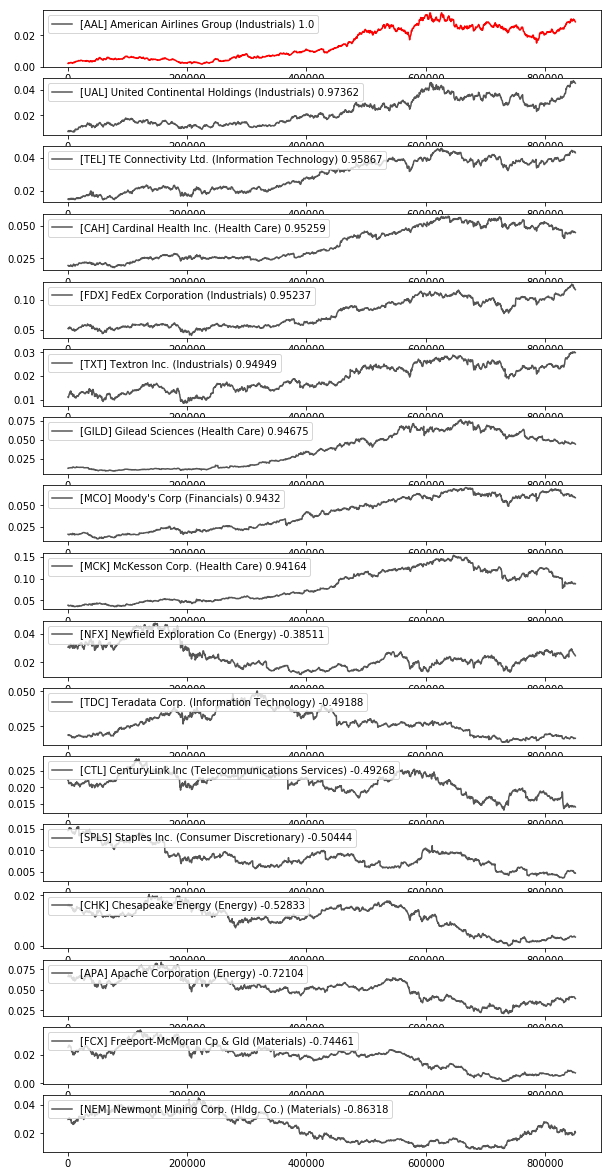

In [8]:
def visualize(selected_companies):
    companies = selected_companies.copy()
    companies.insert(0, (COMPANY_SYMBOL, 1.))
    
    f , plots = subplots(len(companies))
    f.set_figheight(len(selected_companies) + 5)
    f.set_figwidth(10)
    for i, (symbol, corr) in enumerate(companies):
        company = prices[prices.symbol == symbol]
        name = securities[securities['Ticker symbol'] == symbol].Security.iloc[0]
        sector = securities[securities['Ticker symbol'] == symbol]['GICS Sector'].values[0]
        p = plots[i]
        line = p.plot(company.close, label=f'[{symbol}] {name} ({sector}) {corr:.5}', color="#555555")[0]
        p.legend(loc='upper left')
        if i == 0:
            line.set_color('red')

visualize(selected_companies)

## 주가 데이터

In [104]:
def create_stock_data(prices, company, company_names, repeat=1):
    """
    BATCH_SIZE 만큼 x데이터를 읽고, BATCH_SIZE만큼 y를 forcast한다.
    """
    COLUMNS = ['open', 'low', 'high', 'volume', 'close']
    COLUMN_N = len(COLUMNS)
    
    SERIES_N = len(company) - BATCH_SIZE  # 1730
    SERIES_N = SERIES_N - SERIES_N%BATCH_SIZE
    
    # input 데이터의 1차원 vector에 들어가는 item갯수
    VECTOR_N = len(COLUMNS) * (len(selected_companies) + 1)
    
    # Y Matrix 생성
    close_prices = company.close.as_matrix()
    years = company.year.as_matrix()
    
    # X Matrix 생성
    companies = dict()
    for name in company_names:
        matrix = prices[prices.symbol == name][COLUMNS].as_matrix()
        companies[name] = matrix
    
    # x, y 데이터 생성
    x_data = np.zeros((SERIES_N, VECTOR_N))
    y_data = np.zeros((SERIES_N, 1))
    year_data = np.zeros((int(SERIES_N/BATCH_SIZE), 1), dtype='int')
    
    for i in range(SERIES_N):
        for j, name in enumerate(company_names):
            start = j*COLUMN_N
            end = start+COLUMN_N
            x_data[i, start:end] = companies[name][i]
        
        
        y_data[i, 0] = close_prices[i + BATCH_SIZE]
        if i% BATCH_SIZE==0:
            year_data[int(i/BATCH_SIZE), 0] = years[i + BATCH_SIZE]
    
    
    # Reshape
    x_data = x_data.reshape((-1, BATCH_SIZE, VECTOR_N))
    y_data = y_data.reshape((-1, BATCH_SIZE, 1))
    year_data = year_data.reshape((-1, 1))
    
    
    return x_data, y_data, year_data
    
company_names = list(map(lambda x: x[0], selected_companies))
company_names.insert(0, COMPANY_SYMBOL)
x_data, y_data, year_data = create_stock_data(prices, company, company_names, repeat=100)


# Split Train and Test Data
x_train, y_train, year_train = x_data[:TRAIN_SIZE], y_data[:TRAIN_SIZE], year_data[:TRAIN_SIZE]
x_test, y_test, year_test = x_data[TRAIN_SIZE:], y_data[TRAIN_SIZE:], year_data[TRAIN_SIZE:]

x_data shape: (54, 32, 85)
y_data shape: (54, 32, 1)
year   shape: (54, 1)

train_x    shape: (45, 32, 85)
train_y    shape: (45, 32, 1)
train_year shape: (45, 1)
test_x     shape: (9, 32, 85)
test_y     shape: (9, 32, 1)
test_year shape: (9, 1)


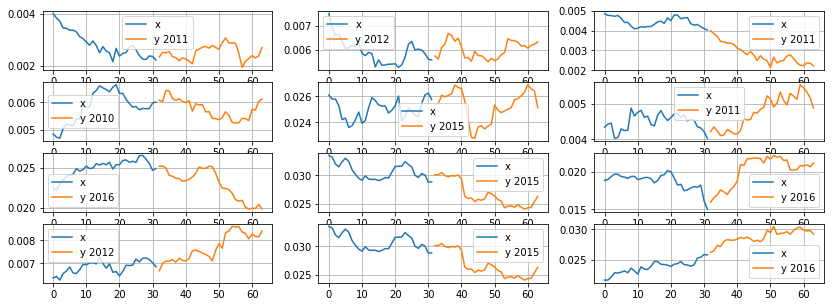

In [105]:
display(HTML('<h3>주가 데이터</h3>'))
print('x_data shape:', x_data.shape)
print('y_data shape:', y_data.shape)
print('year   shape:', year_data.shape)
print()
print('train_x    shape:', x_train.shape)
print('train_y    shape:', y_train.shape)
print('train_year shape:', year_train.shape)
print('test_x     shape:', x_test.shape)
print('test_y     shape:', y_test.shape)
print('test_year shape:', year_test.shape)

def test_price_data(x, y, years):
    t_series = range(BATCH_SIZE*2)
    f, plots = subplots(4, 3)
    f.set_figheight(5)
    f.set_figwidth(14)
    plots = plots.reshape(-1)
    
    for p in plots:
        idx = np.random.randint(x.shape[0])
        year = years[idx][0]
        
        p.plot(t_series[:BATCH_SIZE], x[idx, :, 4], label=f'x')
        p.plot(t_series[BATCH_SIZE:], y[idx], label=f'y {year}')
        
        p.legend()
        p.grid()

test_price_data(x_data, y_data, year_data)

## 재무 데이터

In [12]:
def get_fundamental(symbol:str, year:int):
    if year < 2012:
        year = 2012
    elif year >= 2016:
        year = 2015
        pass
        
    matrix = fundamentals[(fundamentals['Ticker Symbol'] == symbol) & 
                          (fundamentals['For Year'] == year)][FUNDAMENTAL_COLUMNS].as_matrix()
    return matrix

def create_fundamental_data(year_data):
    fundamental_data = np.zeros((year_data.shape[0], len(FUNDAMENTAL_COLUMNS)))
    for i in range(year_data.shape[0]):
        year = year_data[i][0]
        fundamental = get_fundamental(COMPANY_SYMBOL, year)
        fundamental_data[i, :] = fundamental
    return fundamental_data
    
fundamental_data = create_fundamental_data(year_data)
fundamental_data = fundamental_data.reshape((-1, 1, 75))
fundamental_train, fundamental_test = fundamental_data[:TRAIN_SIZE], fundamental_data[TRAIN_SIZE:]

print('fundamental_train shape:', fundamental_train.shape)
print('fundamental_test  shape:', fundamental_test.shape)

fundamental_train shape: (45, 1, 75)
fundamental_test  shape: (9, 1, 75)


# Sampling

In [13]:
def get_train_sample(step:int):
    year = year_train[step][0]
    x_fundamental = get_fundamental(COMPANY_SYMBOL, year)
    
    return x_train[step], y_train[step], x_fundamental, year

sample_x, sample_y, sample_fundamental, year = get_train_sample(0)

# Input Shape으로 사용될 Constants
STOCK_N = sample_x.shape[1]

# Check
print('year         :', year)
print('STOCK_N      :', STOCK_N)

print('sample_x           shape:', sample_x.shape)
print('sample_y           shape:', sample_y.shape)
print('sample_fundamental shape:', sample_fundamental.shape)

year         : 2010
STOCK_N      : 85
sample_x           shape: (32, 85)
sample_y           shape: (32, 1)
sample_fundamental shape: (1, 75)


# Model

In [14]:
def create_fundamental_model():
    model = Sequential(name='fundamental-model')
    model.add(Dense(len(FUNDAMENTAL_COLUMNS), 
                    name='fundamental_layer01', 
                    input_shape=(None, len(FUNDAMENTAL_COLUMNS)) ) )
    model.add(BatchNormalization(name='fundamental_batch01'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(512, name='fundamental_layer02'))
    model.add(BatchNormalization(name='fundamental_batch02'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1024, name='fundamental_layer03'))
    model.add(BatchNormalization(name='fundamental_batch03'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
        
    return model

def create_stock_model():
    model = Sequential(name='stock')
    model.add(Bidirectional(LSTM(256, return_sequences=True), 
                            batch_input_shape=(None, None, STOCK_N)))
    
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    
    return model


def create_model(lstm_out1=5, lstm_out2=5, lstm_out3=5):
    
    stock_model = create_stock_model()
    fundamental_model = create_fundamental_model()
    
    model = Sequential(name='wonder_woman')
    model.add(Merge([stock_model, fundamental_model], mode='concat'))
    
    model.add(Dense(1280, name='affine01'))
    model.add(BatchNormalization(name='batch01'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1024, name='affine02'))
    model.add(BatchNormalization(name='batch02'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(768, name='affine03'))
    model.add(BatchNormalization(name='batch03'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(512, name='affine04'))
    model.add(BatchNormalization(name='batch04'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, name='affine05'))
    model.add(BatchNormalization(name='batch05'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, name='affine06'))
    model.add(BatchNormalization(name='batch06'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64, name='affine07'))
    model.add(BatchNormalization(name='batch07'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, name='affine08'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mean_squared_error])
    return model

# model = create_model()
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

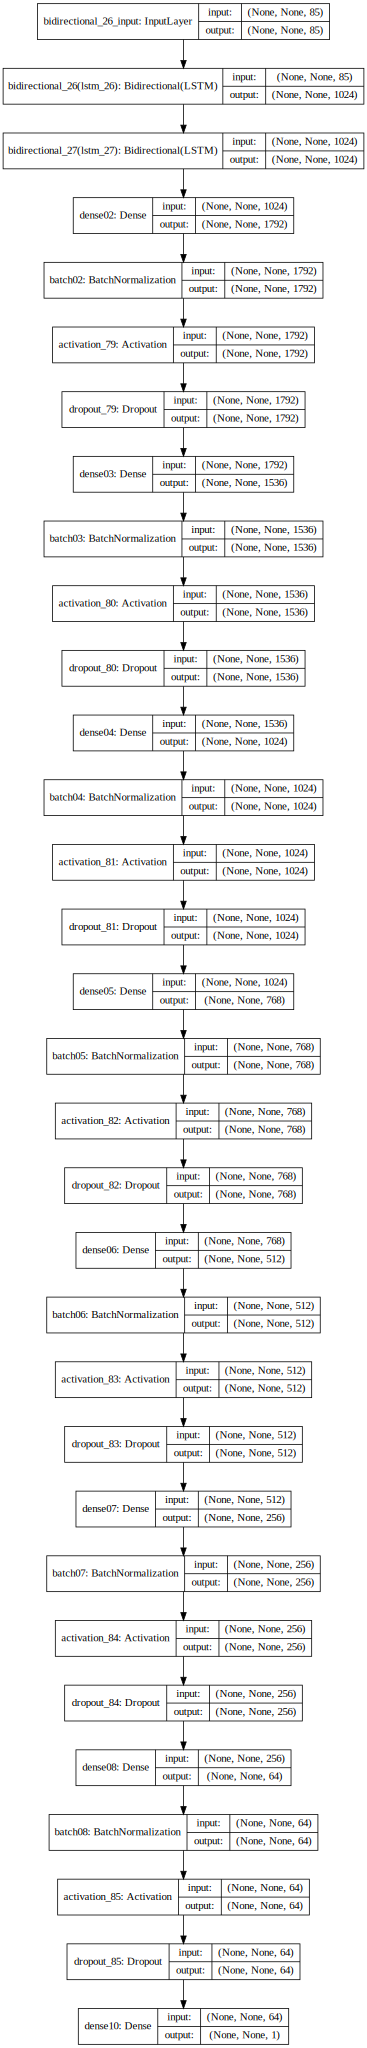

In [114]:
def create_stock_model():
    model = Sequential(name='stock2')
    model.add(Bidirectional(LSTM(512, return_sequences=True), 
                            batch_input_shape=(None, None, STOCK_N)))
    
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    
#     model.add(Bidirectional(LSTM(1024, return_sequences=True)))
    
#     model.add(Dense(2048, name='dense01'))
#     model.add(BatchNormalization(name='batch01'))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))
    
    model.add(Dense(1792, name='dense02'))
    model.add(BatchNormalization(name='batch02'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1536, name='dense03'))
    model.add(BatchNormalization(name='batch03'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1024, name='dense04'))
    model.add(BatchNormalization(name='batch04'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(768, name='dense05'))
    model.add(BatchNormalization(name='batch05'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(512, name='dense06'))
    model.add(BatchNormalization(name='batch06'))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(256, name='dense07'))
    model.add(BatchNormalization(name='batch07'))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(64, name='dense08'))
    model.add(BatchNormalization(name='batch08'))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
#     model.add(Dense(32, name='dense09'))
#     model.add(BatchNormalization(name='batch09'))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.2))
    
    model.add(Dense(1, name='dense10'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[mean_squared_error])
    return model

model = create_stock_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

(9, 32, 85) (9, 32, 1)


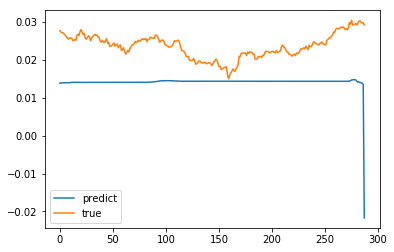

In [120]:
print(x_test.shape, y_test.shape)
d = x_test.reshape((1, -1, 85))

f = y_test.reshape((1, -1, 1))


preds = model.predict([d])

idx = np.random.randint(preds.shape[0]) # , preds.shape, y_test.shape

plot(preds[idx], label='predict')
plot(f[idx], label='true')
legend()

In [115]:
model = create_stock_model()
model.fit([x_train], y_train, epochs=172800, verbose=2)

Epoch 1/172800
4s - loss: 0.7922 - mean_squared_error: 0.7922
Epoch 2/172800
0s - loss: 0.6865 - mean_squared_error: 0.6865
Epoch 3/172800
0s - loss: 0.6247 - mean_squared_error: 0.6247
Epoch 4/172800
0s - loss: 0.5270 - mean_squared_error: 0.5270
Epoch 5/172800
0s - loss: 0.4971 - mean_squared_error: 0.4971
Epoch 6/172800
0s - loss: 0.4423 - mean_squared_error: 0.4423
Epoch 7/172800
0s - loss: 0.3963 - mean_squared_error: 0.3963
Epoch 8/172800
0s - loss: 0.3601 - mean_squared_error: 0.3601
Epoch 9/172800
0s - loss: 0.3482 - mean_squared_error: 0.3482
Epoch 10/172800
0s - loss: 0.3269 - mean_squared_error: 0.3269
Epoch 11/172800
0s - loss: 0.2807 - mean_squared_error: 0.2807
Epoch 12/172800
0s - loss: 0.2617 - mean_squared_error: 0.2617
Epoch 13/172800
0s - loss: 0.2726 - mean_squared_error: 0.2726
Epoch 14/172800
0s - loss: 0.2009 - mean_squared_error: 0.2009
Epoch 15/172800
0s - loss: 0.2198 - mean_squared_error: 0.2198
Epoch 16/172800
0s - loss: 0.2380 - mean_squared_error: 0.2380
E

KeyboardInterrupt: 